In [136]:
# Version 20 of the IB Data Downloader
# ========================================
from ib.opt import ibConnection, message, Connection
from time import sleep
from ib.ext.Contract import Contract
from ib.ext.ContractDetails import ContractDetails
from ib.ext.ExecutionFilter import ExecutionFilter
from ib.ext.Execution import Execution
from ib.ext.CommissionReport import CommissionReport
from ib.ext.Order import Order
import pandas as pd
import numpy as np
import datetime

# Plotting essentials
# ===================
import matplotlib.pyplot as plt
%matplotlib inline

# A Helper Class For Dictionary with Contract as key
class my_contract:
    def __init__(self, contract_, ident_):
        self.con = contract_
        self.ident = ident_
        
    def __hash__(self):
        return hash(self.ident)
    
    def __eq__(self, other):
        signal = ((self.con.m_secType == other.con.m_secType)\
                  and (self.con.m_symbol == other.con.m_symbol)\
                  and (self.con.m_expiry == other.con.m_expiry)\
                  and (self.con.m_strike == other.con.m_strike)\
                  and (self.con.m_right == other.con.m_right))
        return signal
    
    def __ne__(self, other):
        return not(self.con == other.con)
    # Printing Capabilities
    def __repr__(self):
        return " | ".join(["%s = %s" % (a, b) for a, b in vars(self.con).items()])
    def __str__(self):
        return " | ".join(["%s = %s" % (a, b) for a, b in vars(self.con).items()])
    
    # A method for turning the items in a contract into a dataframe
    def to_df(self):
        self.con_df = pd.DataFrame([vars(self.con)])
        return self.con_df
        

# The class
# ====================
class IB_PY():
    def __init__(self):
        # Initializing the dictionary
        # self.val
        
        # For Querying Market Data
        self.mkt_data = pd.DataFrame([{'Bid Size': None, 'Bid': None, 'Ask': None, 'Ask Size': None, 
                      'Last': None, 'Last Size': None, 'High' : None, 'Low': None, 'Volume': None,
                      'Close': None}])
        
        # For Querying Historical Data
        self.hist_data = pd.DataFrame(columns = ['date', 'open', 'high', 'low', 'close']) # For the very recently queried contract
        self.all_hist_data = {} # All the contracts, they are stored by contract instances as keys
        
        # Account Information
        self.account_info = pd.DataFrame()
        # Account Summary
        self.account_summary = pd.DataFrame()
        # Fundamental Data
        self.fundamental_data = None
        # Option Data
        self.option_data = pd.DataFrame()
        self._interim_option_data_dict = {}
        # Account Information
        self.account_info_dict = {}
        # Contract Details
        self.summary_contract = pd.DataFrame()
        self._summary_contract_dict = {}
        self.detail_contract = pd.DataFrame()
        self._detail_contract_dict = {}
        # Executions Over The Past 24hrs
        self.all_executions = {} # A dictionary with contracts as key
        self.this_execution = pd.DataFrame()
        self.all_commissions = pd.DataFrame() # Commmission are not identified by contract 
        self.this_commission = pd.DataFrame()
        # Market Depth
        self.market_depth = pd.DataFrame()
        self.market_depthL2 = pd.DataFrame()
        self.all_market_depth = pd.DataFrame()
        self.all_market_depthL2 = pd.DataFrame()
        # Positions of The Account
        self.all_positions = {} # A dictionary keyed by the contract
        self.all_positions_df = pd.DataFrame()
        # Orders
        self.order_status = pd.DataFrame()
        self.order_state = pd.DataFrame()
        self.all_contract_orders = {} # A dictionary keyed by contracts, value is a list, [0] is order object [1] is order_status
        self.all_contract_open_orders = {} # A dictionary keyed by contracts, value is a list, [0] is order object [1] is order_status
        # Miscellaneous
        self.counter_conId = 0
        
        #------ Ends
        self.end_contract_details = False
        
    def my_acct_handler(self, msg):
        """
        This handler would help us to see the updated account values (? Add details here)
        """
        #print msg.key, type(msg.key), msg.value
        #self.account_info[str(msg.key)] = msg.value
        self.account_info_dict['DateTime'] = datetime.datetime.now()
        if self.account_info_dict.has_key(msg.key):
            #print "in the keys"
            self.account_info_dict[msg.key] = msg.value
        else:
            #print "not in the keys"
            self.account_info_dict[msg.key] = msg.value        
    
    # Summary Handler
    def my_acct_summary_handler(self, msg):
        """
        This handler would help us to see the updated account values (? Add details here)
        """
        print " - In Account Summary Handler -"
        print msg.tag, msg.value
        if hasattr(msg, 'account'):
            self.account_info_dict['account'] = msg.account
        if hasattr(msg, 'tag') and hasattr(msg, 'value') and hasattr(msg, 'currency'):
            if msg.value == None:
                self.account_info_dict[msg.tag] = ' ' + msg.currency
            elif msg.currency == None:
                self.account_info_dict[msg.tag] = msg.value + ' '
            else:
                self.account_info_dict[msg.tag] = msg.value + ' ' + msg.currency
                
        self.account_info_dict['DateTime'] = datetime.datetime.now()


    # Summary Handler End
    def my_acct_summary_end(self, msg):
        print " - End of Account Summary Handler - "
        print msg
        
    # Tick Handler
    def my_tick_handler(self, msg):
        """
        This handler would help us to assign tick size and tick value (? Add details here)
        """
    # Based on what the IB document lays out
        field_dict = {0: 'Bid Size', 1: 'Bid', 2: 'Ask', 3: 'Ask Size', 
                      4: 'Last', 5: 'Last Size', 6: 'High', 7: 'Low', 8: 'Volume',
                      9: 'Close'}
    
        if hasattr(msg, 'price'):
            value = msg.price
        elif hasattr(msg, 'size'):
            value = msg.size
    
        #print('TickerId: ', msg.tickerId, ' Field: ', field_dict[msg.field], ' Value: ', value)
        #print 'Assigning To Self'
        #self.attr.append(field_dict[msg.field]) 
        #self.val.append(value)
        #print 'Done' 
        if msg.field in field_dict.keys():
            #print field_dict[msg.field] This is to prevent KeyError 14 which is for dictionaries in python
            self.mkt_data[[field_dict[msg.field]]] = value
    
    # Account Handler
    def my_hist_data_handler(self, msg):
        #print msg.date, msg.open, msg.high, msg.low, msg.close
        #print msg
        #print ' - In Historical Data Handler - '
        if msg.close != -1:
            interim_df = pd.DataFrame([[msg.date, msg.open, msg.high, msg.low, msg.close, msg.volume, msg.count, msg.WAP, msg.hasGaps]],
                                               columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'count', 'WAP', 'hasGaps'])
            self.hist_data = self.hist_data.append(interim_df, ignore_index = True)
            #print interim_df
        #elif msg.close == -1:
            # print 'done'
            
    def my_hist_option_eod_handler(self, msg):
        #print '- Historical Options Data Handler -'
        if msg.date[10:15] == '15:57': 
            #print ' - In Historical Data Handler - '
            if msg.close != -1:
                interim_df = pd.DataFrame([[msg.date[0:8], msg.open, msg.high, msg.low, msg.close, msg.volume, msg.count, msg.WAP, msg.hasGaps]],
                                                   columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'count', 'WAP', 'hasGaps'])
                self.hist_data = self.hist_data.append(interim_df, ignore_index = True)
    
    def my_hist_option_bod_handler(self, msg):
        #print '- Historical Options Data Handler - '
        if msg.date[10:15] == '09:30': 
            # print ' - In Historical Data Handler - '
            if msg.close != -1:
                interim_df = pd.DataFrame([[msg.date[0:8], msg.open, msg.high, msg.low, msg.close, msg.volume, msg.count, msg.WAP, msg.hasGaps]],
                                                   columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'count', 'WAP', 'hasGaps'])
                self.hist_data = self.hist_data.append(interim_df, ignore_index = True)
    
        
    # Time handler
    def my_acct_time(self, msg):
        print "The time is:"
        print msg.timeStamp
    
    # Position Handler
    def my_position_handler(self, msg):
        """
        This handler gets called as a callback to reqPositions
        """
        print ' - In The Position Handler -'
        #print msg.account, msg.contract.m_symbol, msg.pos
        m_contract = my_contract(msg.contract, msg.contract.m_conId)
        self.all_positions[m_contract] = msg.pos
        # storing the results in a dataframe
        interim_pos_df = m_contract.to_df()
        interim_pos_df['size_position'] = msg.pos
        if self.all_positions_df.shape[0] == 0:
            self.all_positions_df = interim_pos_df
        else:
            self.all_positions_df = self.all_positions_df.append(interim_pos_df, ignore_index = True)
    
    # Position Handler End
    def my_position_end(self, msg):
        print ' - End of Querying Positions - '
    
    def my_fundamental_handler(self, msg):
        print ' - In The Fundamental Data - '
        self.fundamental_data = msg.data
    
    # Option Handler
    def my_option_handler(self, msg):
        """
        handling tickOptionComputation
        """
        # print msg.impliedVol, msg.delta
        self._interim_option_data_dict['Implied Volatility'] = msg.impliedVol
        self._interim_option_data_dict['Delta'] = msg.delta
        self._interim_option_data_dict['Option Price'] = msg.optPrice
        self._interim_option_data_dict['Present Value Dividend'] = msg.pvDividend
        self._interim_option_data_dict['Gamma'] = msg.gamma
        self._interim_option_data_dict['Vega'] = msg.vega
        self._interim_option_data_dict['Theta'] = msg.theta
        self._interim_option_data_dict['Underlying Price'] = msg.undPrice
        self._interim_option_data_dict['DateTime'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Contract Handler
    def my_contract_handler(self, msg):
        print ' - Getting the Contract Details - '
        self._detail_contract_dict = vars(msg.contractDetails)
        #for a, b in specs.items():
        #    if a not in ['m_summary']:
        #        print a, b
        # print " - printing the contract - "
        self._summary_contract_dict = vars(msg.contractDetails.m_summary)
        #print self._summary_contract_dict
        self.store_contract_detail_summary(self._detail_contract_dict, self._summary_contract_dict)
        
    # End of contract handler
    def my_contract_end(self, msg):
        self.end_contract_details = True
        print ' - End of Contract Details - '
    
    # Execution handler
    def my_execution_handler(self, msg):
        print ' - In Execution Handler - '
        self.this_execution = pd.DataFrame([vars(msg.execution)])
        self.store_executions(msg.contract, msg.contract.m_conId)
        
    # Commission handler
    def my_commission_handler(self, msg):
        print ' - In Commission Handler - '
        #print pd.DataFrame(vars(msg.commissionReport))
        self.this_commission = pd.DataFrame([vars(msg.commissionReport)])
        self.all_commissions = pd.concat([self.this_commission, self.all_commissions], axis = 0, join = 'outer',
                                         ignore_index = True, copy = True)
        
    # Execution End
    def my_execution_end(self, msg):
        print ' - End of Execution Handler - '
        
    # Market Depth Handler
    def my_market_depth_handler(self, msg):
        print ' - Market Depth - '
        operation_dict = {0: 'insert', 1:'update', 2:'delete'}
        side_dict = {0:'ask', 1:'bid'}
        #print msg.price, msg.size
        self.market_depth = pd.DataFrame([[msg.position, operation_dict[msg.operation], side_dict[msg.side], msg.price, msg.size]],
                                               columns = ['position', 'operation', 'side', 'price', 'size'])
        self.all_market_depth = pd.concat([self.market_depth, self.all_market_depth], axis = 0, join = 'outer', ignore_index = True,
                                          copy = True)
        
    # Market Depth Level 2 Handler
    # def my_market_depthL2_handler(self, msg):
    #    """
    #    THIS IS NOT TESTED
    #    """
    #    print ' - Level II Market Depth - '
    #    self.market_depthL2 = pd.DataFrame([vars(msg)])
    #    self.all_market_depthL2 = pd.concat([self.market_depthL2, self.all_market_depthL2], axis = 0, join = 'outer', 
    #                                        ignore_index = True, copy = True)
        
    # Open orders
    def my_order_status_handler(self, msg):
        print ' - Order Status Handler - '
        #print msg.orderId, msg.status, msg.filled, msg.remaining, msg.remaining
        #print vars(msg)
        interim = pd.DataFrame([[msg.orderId, msg.status, msg.filled, msg.remaining, msg.avgFillPrice, msg.permId, msg.parentId,
                            msg.lastFillPrice, msg.clientId, msg.whyHeld]], 
                          columns = ['orderId', 'status', 'filled', 'remaining', 'avgFillPrice', 'permId', 'parentId', 
                                     'lastFillPrice', 'cliendId', 'whyHeld'])
        self.order_status = pd.concat([self.order_status, interim], axis = 0, join = 'outer', copy = True, ignore_index = True)
        
    # Open order handler
    def my_open_order_handler(self, msg):
        print ' - Open Orders Handler - '
        #print vars(msg.orderState)
        self.order_state = pd.DataFrame([vars(msg.orderState)])
        m_contract = my_contract(msg.contract, msg.contract.m_conId)
        self.all_contract_open_orders[m_contract] = [msg.order, self.order_state]
        
    # Open orders End
    def my_open_order_end(self, msg):
        print ' - End of Open Orders - '
        
    # The general handler - WATCHER!!    
    def watcher(self, msg):
        print msg
    
    # ======================= Intermediary Methods
    # =============================================
    
    def make_contract(self, **kwargs):
        """
        A contract needs items below
        
        m_conId: unique identifier
        m_currency: 'USD'
        m_exchange: 'SMART'
        m_expiry: '20170120'
        m_multiplier: '100'
        m_right: 'PUT, CALL, P, C'
        m_secType: 'STK, OPT, FUT, IND, CASH, FOP, BAG, NEWS'
        m_strike: '100.00'
        m_symbol: 'AAPL'
        
        """
        cont = Contract()
        cont.m_exchange = 'SMART'
        cont.m_currency = 'USD'
        for name, value in kwargs.items():
            if not isinstance(name, basestring) or not isinstance(value, basestring):
                raise('Contract keywords are not set right! It should start with m_. They should both be strings as well.')
            setattr(cont, 'm_' + name, value)
        return cont
        
    # Make an order 
    def make_order(self, **kwargs):
        """
        This method helps to build an order object
        
        * m_orderId = The id for the order
        m_clientId the id of the client
        m_permid unique TWS id for orders, remains the same as long as TWS is connected
        -----
        * m_action: BUY, SELL
        m_auxPrice: 
        * m_lmtPrice: Limit price for limit orders
        * m_orderType: order types that are supported, STP STP LMT, LMT, MKT, ...
        * m_totalQuantity: order quantity
        ------
        * m_ocaGroup: The OneCancelsAll group
        * m_ocaType: 1 = calcel all remaining orders
        m_outsideRth: true, false - trading outside regular tradinhg hours
        * m_tif : DAY, GTC, IOC, GTD. time in force
        
        * The necessary fields
        """
        order = Order()
        for name, value in kwargs.items():
            if not isinstance(name, basestring) or not isinstance(value, basestring):
                raise('Contract keywords are not set right! They should both be strings.')
            setattr(order, 'm_' + name, value)
        return order
    
    # ExecutionFilter maker
    def make_exec_filter(self, **kwargs):
        """
        This function helps us to filter a executio based on its attributes
        
        m_acctCode - String
        m_exchange - String
        m_secType - String
        m_side - String
        m_symbol - String
        m_time - String 'yyyymmdd-hh:mm:ss'
        m_clientId - int
        
        """
        ex_filter = ExecutionFilter()
        for name, value in kwargs.items():
            if not isinstance(name, basestring) or not isinstance(value, basestring):
                raise('Contract keywords are not set right! It should start with m_. They should both be strings as well.')
            setattr(ex_filter, 'm_' + name, value)
        return ex_filter
    
    # Storing the historical data
    def store_historical_data(self, contract_, local_id_):
        """
        This method helps to store the results into a dictionary with keys as cumstom classes
        Remember that the identifier is NOT the conId from the IB
        """
        if not self.hist_data.empty:
            keys = self.all_hist_data.keys()
            m_contract = my_contract(contract_, ident_ = local_id_)
            if m_contract in keys:
                interim_df = pd.concat([self.all_hist_data[m_contract], self.hist_data], 
                                                          axis = 0, join = 'outer', ignore_index = True, copy = True)
                self.all_hist_data[m_contract] = None
                self.all_hist_data[m_contract] = interim_df

                # Unique on dates
                # ...
            else:
                self.all_hist_data[m_contract] = self.hist_data.copy()

            print ' - Stored The Results - '
        else:
            print ' - Nothing Stored, Query came back empty - '

    def store_executions(self, contract_, local_id_):
        """
        This method helps to store the execution details of the contracts
        """
        keys = self.all_executions.keys()
        m_contract = my_contract(contract_, ident_ = local_id_)
        if m_contract in keys:
            interim_df = pd.concat([self.all_executions[m_contract], self.this_execution], 
                                                      axis = 0, join = 'outer', ignore_index = True, copy = True)
            self.all_executions[m_contract] = None
            self.all_executions[m_contract] = interim_df
            
            # Unique on dates
            # ...
        else:
            self.all_executions[m_contract] = self.this_execution.copy(deep = True)
        
        print ' - Stored The Results - '
    
    # Storing the contract details
    def store_contract_detail_summary(self, detail_dict, summary_dict):
        # Let us store it now that the callback function is finished
        self.summary_contract = pd.concat([self.summary_contract, pd.DataFrame([summary_dict])],
                                          ignore_index = True, axis = 0, copy = True)
        self.detail_contract = pd.concat([self.detail_contract, pd.DataFrame([detail_dict])],
                                         ignore_index = True, axis = 0, copy = True)
        print ' - Stored Contract Summary & Details - '
    
    
    def get_conId(self, sameContract = False):
        """
        Generates the conId for IB. It has purposes for a dictionary of Contract-type keys. sameContract is a control over generating conId's.
        """
        if sameContract:
            return self.counter_conId
        else:
            self.counter_conId += 1
            return self.counter_conId
        
    # ======================= Getter Methods
    # ======================================
    def get_updates(self):
        """
        This method helps us to get the historical data. It is not written in the most optimal way yet.
        This gets called by IB.
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        con.register(self.my_acct_handler, 'UpdateAccountValue')
        con.register(self.my_tick_handler, message.tickPrice, message.tickSize)
        con.register(self.my_hist_data_handler, message.historicalData)
        # Setting up the connection
        con.connect()
        
        # Sleep
        sleep(3)

        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def get_account_updates(self):
        # Connection object
        con = ibConnection(port=4001, clientId=998)
        # registering the handler
        con.register(self.my_acct_handler, 'UpdateAccountValue')
        con.register(self.my_acct_time, 'UpdateAccountTime')
        # Connect to IB! 
        con.connect()
        # Request updates
        con.reqAccountUpdates(1, '')
        # Sleep
        sleep(5)
        # Disconnecting
        print('Disconnected', con.disconnect())
        
        self.account_info = self.account_info.append(pd.DataFrame([self.account_info_dict]), ignore_index=True)
        
    def get_account_summary(self, items = 'AccountType'):
        # Connection object
        con = ibConnection(port=4001, clientId=998)
        # registering the handler
        con.register(self.my_acct_summary_handler, message.accountSummary)
        con.register(self.my_acct_summary_end, message.accountSummaryEnd)
        # Connect to IB! 
        con.connect()
        # Request updates
        con.reqAccountSummary(1, 'All', items)
        # Sleep
        sleep(2)
        # Canceling the request
        con.cancelAccountSummary(1)
        # Disconnecting
        print('Disconnected', con.disconnect())
        
        self.account_summary = self.account_summary.append(pd.DataFrame([self.account_info_dict]), ignore_index=True)
        
    def get_positions(self):
        # Connection object
        con = ibConnection(port=4001, clientId=998)
        # Registering Handlers
        con.register(self.my_position_handler, message.position)
        con.register(self.my_position_end, message.positionEnd)
        # Connect to IB! 
        con.connect()
        # Request updates
        con.reqPositions()
        # Sleep
        sleep(2)
        # Canceling the request
        con.cancelPositions()
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def get_fundamentals(self, contract_, ReportType_ = 'ReportSnapshot'):
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=999)
        # Registering Handlers
        con.register(self.my_fundamental_handler, message.fundamentalData)
        # Setting up the connection
        con.connect()

        con.reqFundamentalData(1, contract_, ReportType_)
        sleep(10)
        con.cancelFundamentalData(1)
        
        # Disconnecting from the server
        print('Disconnected', con.disconnect())
        
    def get_implied_vol(self):
        """
        calculates the implied vol for a given contract, underlying price and the option price
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=999)
        # Registering Handlers
        # con.registerAll(self.watcher)
        con.register(self.my_option_handler, message.tickOptionComputation)
        # Setting up the connection
        con.connect()

        # Defining the contract
        asset = Contract()
        asset.m_symbol = 'GS'
        asset.m_secType = 'OPT'
        asset.m_exchange = 'SMART'
        asset.m_currency = 'USD'
        asset.m_strike = str(245.00)
        asset.m_right = 'CALL'
        asset.m_expiry = '20161230'
        asset.m_multiplier = '100'
        
        
        con.calculateImpliedVolatility(1, asset, 0.92, 240.12)
        sleep(2)
        con.cancelCalculateImpliedVolatility(1)
        
        # Assigning The Contract Characteristics To The interim_data
        attrs_contract = vars(asset)
        for a, b in attrs_contract.items():
            self._interim_option_data_dict[str(a)] = b
        self._interim_option_data_dict['CalcImpVol'] = 'True'
        # Attaching to the permanent DataFrame
        self.option_data = self.option_data.append(pd.DataFrame([self._interim_option_data_dict]), ignore_index = True)
        # Disconnecting from the server
        print('Disconnected', con.disconnect())
        
    def get_option_price(self):
        """
        Calculates the option price for a given implied volatility, and option contract
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=999)
        # Registering Handlers
        #con.registerAll(self.watcher)
        con.register(self.my_option_handler, message.tickOptionComputation)
        # Setting up the connection
        con.connect()

        # Defining the contract
        asset = Contract()
        asset.m_symbol = 'GS'
        asset.m_secType = 'OPT'
        asset.m_exchange = 'SMART'
        asset.m_currency = 'USD'
        asset.m_strike = str(245.00)
        asset.m_right = 'CALL'
        asset.m_expiry = '20161230'
        asset.m_multiplier = '100'
        
        
        con.calculateOptionPrice(1, asset, 0.18, 241.25)
        sleep(2)
        con.cancelCalculateOptionPrice(1)
        
        # Assigning The Contract Characteristics To The interim_data
        attrs_contract = vars(asset)
        for a, b in attrs_contract.items():
            self._interim_option_data_dict[str(a)] = b
        self._interim_option_data_dict['CalcImpVol'] = 'False'
        # Attaching to the permanent DataFrame
        self.option_data = self.option_data.append(pd.DataFrame([self._interim_option_data_dict]), ignore_index = True)
        # Disconnecting from the server
        print('Disconnected', con.disconnect())
        
    def get_contract_details(self, contract_ = Contract()):
        """
        Calculates the option price for a given implied volatility, and option contract
        """
        # First step is to define a dictionary will will be populated by IB API
        con = ibConnection(port=4001, clientId=999)
        # Registering Handlers
        #con.registerAll(self.watcher)
        con.register(self.my_contract_handler, message.contractDetails)
        con.register(self.my_contract_end, 'ContractDetailsEnd')
        # Setting up the connection
        con.connect()

        # This is an asynchronous callback method I am building to make sure the call to a method is finished
        con.reqContractDetails(1, contract_)
        ticker = 0
        while not self.end_contract_details and ticker < 100:
            sleep(1)
            ticker += 1
        
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def get_execution(self, executionFilter_ = ExecutionFilter()):
        """
        Getting the details of the execution within the past 24 hours. Commission reports as well
        
        An executionFilter needs to be passed in
        """
        # First step is to define a dictionary will will be populated by IB API
        con = ibConnection(port=4001, clientId=999)
        
        # Registering Handlers
        #con.registerAll(self.watcher)
        con.register(self.my_execution_handler, message.execDetails)
        con.register(self.my_commission_handler, message.commissionReport)
        con.register(self.my_execution_end, message.execDetailsEnd)
        
        # Setting up the connection
        con.connect()
        
        # Cleaning up the this_execution first
        if not self.this_execution.empty:
            self.this_execution.drop(range(self.this_execution.shape[0]), inplace=True)
        # Cleaning up the this_commission first
        if not self.this_commission.empty:
            self.this_commission.drop(range(self.this_commission.shape[0]), inplace=True)
            
        # Asking the execution details
        #filter_in = self.make_exec_filter(secType = 'BAG')
        con.reqExecutions(1, executionFilter_)
        sleep(5)
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def get_historical_data(self, 
                            contract_ = Contract(),
                            endDateTime_ = datetime.datetime.now(),
                            durationStr_ = '1 Y',
                            barSizeSetting_ = '1 day',
                            whatToShow_ = 'MIDPOINT',
                            useRTH_ = 0,
                            formatDate_ = 1,
                            sameContract_ = False):
        """
        This function helps to get the historical data for one single contract 
        This method helps us to get the historical data. It is not written in the most optimal way yet.
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        #con.registerAll(self.watcher)
        con.register(self.my_hist_data_handler, message.historicalData)
        # Setting up the connection
        con.connect()
        
        # Building the contract
        #aapl = self.make_contract(secType = 'STK', symbol = 'AAPL')
        
        # First we should clean up the temporary dataframe of ours
        if not self.hist_data.empty:
            self.hist_data.drop(range(self.hist_data.shape[0]), inplace=True)
        
        # Putting the request in
        con.reqHistoricalData(tickerId = 1, 
                              contract = contract_, 
                              endDateTime = endDateTime_.strftime("%Y%m%d %H:%M:%S %Z"), 
                              durationStr = durationStr_, 
                              barSizeSetting = barSizeSetting_, 
                              whatToShow = whatToShow_, 
                              useRTH = useRTH_, 
                              formatDate = formatDate_)

        
        # Sleep
        sleep(5)
        # Canceling the request
        con.cancelHistoricalData(tickerId = 1)
        # Adding One Thing Before Storing The Contract
        self.hist_data['whatToShow'] = whatToShow_
        self.hist_data['Ticker'] = contract_.m_symbol
        self.hist_data.date = pd.to_datetime(self.hist_data.date)
        # Storing The Data
        conId = self.get_conId(sameContract = sameContract_)
        print ' - Sending to historical data handler - '
        self.store_historical_data(contract_, conId)
        print ' - Done with historical data handler - '
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def get_market_depth(self, contract_ = Contract(), numRows_ = 5):
        """
        This mathod helps to get the depth of the market before placing an order
        
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        #con.registerAll(self.watcher)
        con.register(self.my_market_depth_handler, 'UpdateMktDepth')
        # Setting up the connection
        con.connect()
        # Cleaning up the market depth
        self.market_depth.drop(range(self.market_depth.shape[0]), inplace=True)
        self.market_depthL2.drop(range(self.market_depthL2.shape[0]), inplace=True)
        self.all_market_depth.drop(range(self.all_market_depth.shape[0]), inplace=True)
        self.all_market_depthL2.drop(range(self.all_market_depthL2.shape[0]), inplace=True)
        # Requesting the market depth
        con.reqMktDepth(1, contract_, numRows_)
        # Sleep
        sleep(1)
        # Canceling the request
        con.cancelMktDepth(tickerId = 1)
        # Storing The Data
        # ...
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def put_order(self, contract_ = Contract(), order_ = Order()):
        """
        This function places an order to the exchange
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        con.registerAll(self.watcher)
        # Setting up the connection
        con.connect()
        con.placeOrder(order_.m_orderId, contract_, order_)
        # Sleep
        sleep(5)
        # Disconnecting
        print('Disconnected', con.disconnect())
        # Storing the orders based on contracts
        m_contract = my_contract(contract_, contract_.m_conId)
        self.all_contract_orders[m_contract] = order_
        
    def cancel_order(self, orderId_ = 1):
        """
        This method is called is to cancel open orders
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        con.registerAll(self.watcher)
        # Setting up the connection
        con.connect()
        con.cancelOrder(orderId_)
        # Sleep
        sleep(5)
        # Disconnecting
        print('Disconnected', con.disconnect())
    
    def get_open_orders(self):
        """
        This method helps us to get all open orders
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        #con.registerAll(self.watcher)
        con.register(self.my_order_status_handler, message.orderStatus)
        con.register(self.my_open_order_handler, message.openOrder)
        con.register(self.my_open_order_end, message.openOrderEnd)
        # Setting up the connection
        con.connect()
        con.reqAllOpenOrders()
        # Sleep
        sleep(5)
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def cancel_all_open_orders(self):
        """
        This method cancels all open orders
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        con.registerAll(self.watcher)
        # Setting up the connection
        con.connect()
        con.reqGlobalCancel()
        # Sleep
        sleep(2)
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    def get_eod_options(self, 
                        contract_ = Contract(), 
                        eod_or_bod = True, # EOD or BOD options? 
                        whatToShow_ = 'MIDPOINT',
                        endDateTime_ = datetime.datetime.now(),
                        numOfWeeks_ = 1,
                        sameContract_ = False):
        """
        The method returns EOD (3 min before close) and BOD data for options. It uses a different handler
        
        Contract: Specifies the contract we are querying. ib.ext.Contract 
        eod_or_bod: end of the day or beginning of the day. Boolean
        whatToShow: TRADE, MIDPOINT, BID, ASK, BID_ASK. From IB, string.
        endDateTime_: The last datetime that you would like to be queried. datetime is the right format.
        numOfWeeks_: number of weekes we are iterating over. int
        sameContract_: For storage purposes, if it is indeed the same contract then get_conId would return the same id
        """
        # First step is to define a dictionary whill will be populated by IB API
        con = ibConnection(port=4001, clientId=998)
        #con.registerAll(self.watcher)
        #con.register(self.my_hist_data_handler, message.historicalData)
        #con.register(self.my_hist_option_eod_handler, message.historicalData)
        if eod_or_bod:
            con.register(self.my_hist_option_eod_handler, message.historicalData)
        else:
            con.register(self.my_hist_option_bod_handler, message.historicalData)
        # Setting up the connection
        con.connect()
        
        # First we should clean up the temporary dataframe of ours
        if not self.hist_data.empty:
            self.hist_data.drop(range(self.hist_data.shape[0]), inplace=True)
        
        # Putting the request in
        weekEnd = endDateTime_
        for i in xrange(numOfWeeks_):
            con.reqHistoricalData(tickerId = i, 
                                  contract = contract_, 
                                  endDateTime = weekEnd.strftime("%Y%m%d %H:%M:%S %Z"), 
                                  durationStr = '1 W', 
                                  barSizeSetting = '3 mins', 
                                  whatToShow = whatToShow_, 
                                  useRTH = 0, 
                                  formatDate = 1)
            sleep(2)
            print ' - Iteration %s Completed - ' % i
            weekEnd = weekEnd - datetime.timedelta(days = 7)
 
        # Sleep
        sleep(1)
        # Canceling the request
        con.cancelHistoricalData(tickerId = 1)
        # Adding One Thing Before Storing The Contract
        self.hist_data['whatToShow'] = whatToShow_
        self.hist_data['Ticker'] = contract_.m_symbol
        self.hist_data.date = pd.to_datetime(self.hist_data.date)
        # Storing The Data
        conId = self.get_conId(sameContract = sameContract_)
        self.store_historical_data(contract_, conId)
        # Disconnecting
        print('Disconnected', con.disconnect())
        
    # these functions are helpful for post-trade analysis. 
    # On the account level and on the position level
    
    def summarize_account(self):
        """
        This function leverages the get_account_updates to glance and the summary of the account. 
        We can add other fields if need be to get a better picture of the account. 
        
        """
        self.get_account_updates()
        df_update = self.account_info.loc[:,['DateTime', 'AccountCode', 'RealizedPnL', 'UnrealizedPnL', 'RealCurrency', 'Currency',\
                                     'OptionMarketValue', 'StockMarketValue', 'FxCashBalance', 'TBondValue', \
                                      'SMA', 'PreviousDayEquityWithLoanValue', 'CashBalance', 'TotalCashValue', 'NetLiquidation',\
                                     'TotalCashBalance', 'EquityWithLoanValue-C']].copy(deep = True)
        self.get_account_summary()
        df_summary = self.account_summary.loc[:,['DateTime', 'AccountCode', 'AvailableFunds', 'BuyingPower', 'CashBalance', 'Currency',\
                                     'CorporateBondValue', 'EquityWithLoanValue', 'FullInitMarginReq', 'FundValue', \
                                      'FutureOptionValue', 'FuturesPNL', 'FxCashBalance', 'MaintMarginReq', 'MoneyMarketFundValue',\
                                     'MutualFundValue', 'NetLiquidation', 'OptionMarketValue', 'PreviousDayEquityWithLoanValue',\
                                    'RealizedPnL', 'RegTEquity', 'RegTMargin', 'SMA', 'StockMarketValue',\
                                    'TBillValue', 'TBondValue', 'TotalCashValue', 'TotalCashBalance', 'UnrealizedPnL']].copy(deep = True)
        
        return tuple([df_update, df_summary])
    
    # The function in this section store the results for post-trade analysis
    def all_account_eod_update(self, paper = True, innitialize = False):
        print '- Getting The Latest Account Info -'
        df_update, df_summary = api.summarize_account()
        
        # 
        if paper:
            path_ = '/Users/HoumanDehghan/Documents/IB_Acct_Info/Paper_Acct/'
        else:
            print 'Live Account'
            path_ = '/Users/HoumanDehghan/Documents/IB_Acct_Info/Live_Acct/'
        if(innitialize):
            hdf = pd.HDFStore(path = (path_ + 'storage.h5'))
            hdf.put('all_acct_info/all_acct_update', api.account_info, format = 'table', data_columns = True)
            hdf.put('all_acct_info/all_acct_summary', api.account_summary, format = 'table', data_columns = True)
            hdf.put('all_acct_info/all_acct_update_summarized', df_update, format = 'table', data_columns = True)
            hdf.put('all_acct_info/all_acct_summary_summarized', df_summary, format = 'table', data_columns = True)
            hdf.close()
        else:
            hdf = pd.HDFStore(path = (path_ + 'storage.h5'))
            hdf.append('all_acct_info/all_acct_update', api.account_info, data_columns = True)
            hdf.append('all_acct_info/all_acct_summary', api.account_summary, data_columns = True)
            hdf.append('all_acct_info/all_acct_update_summarized', df_update, data_columns = True)
            hdf.append('all_acct_info/all_acct_summary_summarized', df_summary, data_columns = True)
            hdf.close()
        print '- Done -'
        
    def all_account_pnl_by_contract(self, paper = True, innitialize = False):
        print '- Getting The Latest Account Info -'
        # Calculating the PnL
        self.get_execution()
        
        tot_ar = np.empty((0, 11))
        for i, j in self.all_executions.items():
            interim_ar = np.hstack([np.tile(np.array([i.con.m_symbol, i.con.m_secType, i.con.m_strike, i.con.m_expiry, i.con.m_right]), (2, 1)),\
                                    np.array([j.m_time.values, j.m_cumQty, j.m_avgPrice, j.m_side, j.m_exchange, j.m_execId]).T])
            tot_ar = np.vstack([tot_ar, interim_ar])
        
        interim_df = pd.DataFrame(tot_ar,\
                                  columns=['Ticker', 'Type', 'Strike', 'Expiry', 'Right', 'Time', 'Quantity', 'AvgPrice', 'Side', 'Exchange', 'Execution_Id'],\
                                  index = range(tot_ar.shape[0]))
        interim_df = interim_df.merge(self.all_commissions.loc[:, ['m_execId', 'm_commission']], left_on='Execution_Id', right_on='m_execId', how='inner')
        interim_df.drop(['m_execId', 'Execution_Id'], inplace=True, axis = 1)
        interim_df = interim_df.astype(dtype = str)
        #
        
        if paper:
            path_ = '/Users/HoumanDehghan/Documents/IB_Acct_Info/Paper_Acct/'
        else:
            print 'Live Account'
            path_ = '/Users/HoumanDehghan/Documents/IB_Acct_Info/Live_Acct/'
        
        if(innitialize):
            hdf = pd.HDFStore(path = (path_ + 'storage.h5'))
            hdf.put('all_acct_info/all_acct_pnl_by_position', interim_df, format = 'table', data_columns = True)
            hdf.close()
        else:
            hdf = pd.HDFStore(path = (path_ + 'storage.h5'))
            hdf.append('all_acct_info/all_acct_pnl_by_position', interim_df, data_columns = True)
            hdf.close()
        print '- Done -'

In [137]:
api = IB_PY()

In [4]:
cont = api.make_contract(symbol = 'AAPL', secType = 'STK', currency = 'USD', exchange = 'SMART')

In [5]:
api.get_historical_data(contract_= cont)

Server Version: 76
TWS Time at connection:20180203 11:19:23 EST
 - Sending to historical data handler - 
 - Stored The Results - 
 - Done with historical data handler - 
('Disconnected', True)


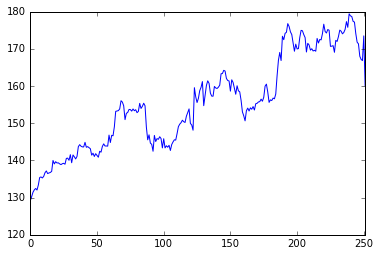

In [6]:
# The api worked fine.
# Now I disable the print
df = api.hist_data
df.close.plot()

1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information.

In [11]:
api.get_account_updates()

Server Version: 76
TWS Time at connection:20171225 12:51:51 EST
The time is:
12:03
The time is:
12:03
The time is:
12:51
('Disconnected', True)


In [13]:
print api.account_info

  AccountCode AccountOrGroup AccountReady AccountType AccruedCash  \
0    DU496278       DU496278         true  INDIVIDUAL         433   

  AccruedCash-C AccruedCash-S AccruedDividend AccruedDividend-C  \
0          0.00        433.14            0.00              0.00   

  AccruedDividend-S       ...       TBillValue TBondValue TotalCashBalance  \
0              0.00       ...                0          0           992285   

  TotalCashValue TotalCashValue-C TotalCashValue-S TradingType-S  \
0      991379.43          5037.83        986341.60       STKNOPT   

  UnrealizedPnL WarrantValue WhatIfPMEnabled  
0           219            0            true  

[1 rows x 120 columns]


In [14]:
print api.account_info_dict

{'DayTradesRemaining': '-1', 'RealizedPnL': '0', 'DateTime': datetime.datetime(2017, 12, 25, 12, 51, 52, 871440), 'FutureOptionValue': '0', 'AccountCode': 'DU496278', 'FullAvailableFunds-S': '987830.47', 'RealCurrency': 'USD', 'OptionMarketValue': '0', 'GrossPositionValue-S': '4694.84', 'PreviousDayEquityWithLoanValue': '989782.01', 'UnrealizedPnL': '219', 'TotalCashBalance': '992285', 'FullAvailableFunds-C': '5037.83', 'FundValue': '0', 'FullInitMarginReq': '2000.00', 'LookAheadInitMarginReq': '2000.00', 'EquityWithLoanValue-C': '5037.83', 'NetLiquidationByCurrency': '995775', 'FullExcessLiquidity-C': '5037.83', 'EquityWithLoanValue-S': '989830.47', 'FullExcessLiquidity-S': '987831.58', 'StockMarketValue': '3057', 'FxCashBalance': '0', 'TBondValue': '0', 'Guarantee-C': '0.00', 'AccruedDividend': '0.00', 'IndianStockHaircut-C': '0.00', 'Guarantee-S': '0.00', 'LookAheadExcessLiquidity': '992869.41', 'InitMarginReq': '2000.00', 'IndianStockHaircut-S': '0.00', 'IssuerOptionValue': '0', 'G

Our attempt is to store all the account data in an HDF5 data.

In [23]:
hdf = pd.HDFStore(path='/Users/HoumanDehghan/Documents/IB_Acct_Info/Paper_Acct/storage.h5')

In [24]:
hdf.put('all_acct_info/all_acct', api.account_info, format = 'table', data_columns = True)

/Users/HoumanDehghan/anaconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'AccruedCash-C'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/Users/HoumanDehghan/anaconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'AccruedCash-S'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/Users/HoumanDehghan/anaconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'AccruedDividend-C'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; usi

In [25]:
# Querying the same table again and appending to it
api.get_account_updates()

Server Version: 76
TWS Time at connection:20171225 13:28:56 EST
The time is:
12:03
The time is:
12:03
The time is:
13:27
('Disconnected', True)


In [26]:
hdf.append('all_acct_info/all_acct', api.account_info, data_columns = True)

In [27]:
# Validating the new data
test = hdf.get('all_acct_info/all_acct')

In [31]:
test.head()

,AccountCode,AccountOrGroup,AccountReady,AccountType,AccruedCash,AccruedCash-C,AccruedCash-S,AccruedDividend,AccruedDividend-C,AccruedDividend-S,...,TBillValue,TBondValue,TotalCashBalance,TotalCashValue,TotalCashValue-C,TotalCashValue-S,TradingType-S,UnrealizedPnL,WarrantValue,WhatIfPMEnabled
0,DU496278,DU496278,true,INDIVIDUAL,433,0.00,433.14,0.00,0.00,0.00,...,0,0,992285,991379.43,5037.83,986341.60,STKNOPT,219,0,true
0,DU496278,DU496278,true,INDIVIDUAL,433,0.00,433.14,0.00,0.00,0.00,...,0,0,992285,991379.43,5037.83,986341.60,STKNOPT,219,0,true
1,DU496278,DU496278,true,INDIVIDUAL,433,0.00,433.14,0.00,0.00,0.00,...,0,0,992285,991379.43,5037.83,986341.60,STKNOPT,219,0,true


1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information. Test was successful. Was able to save the data in HDF5 format.
3. Test: Query account's summary. 

In [32]:
api.get_account_summary()

Server Version: 76
TWS Time at connection:20171225 13:36:35 EST
in accountSummaryEnd
<accountSummaryEnd reqId=1>
('Disconnected', True)


In [34]:
print api.account_summary

  AccountCode AccountOrGroup AccountReady  AccountType AccruedCash  \
0    DU496278       DU496278         true  INDIVIDUAL          433   

  AccruedCash-C AccruedCash-S AccruedDividend AccruedDividend-C  \
0          0.00        433.14            0.00              0.00   

  AccruedDividend-S    ...    TBondValue TotalCashBalance TotalCashValue  \
0              0.00    ...             0           992285      991379.43   

  TotalCashValue-C TotalCashValue-S TradingType-S UnrealizedPnL WarrantValue  \
0          5037.83        986341.60       STKNOPT           219            0   

  WhatIfPMEnabled   account  
0            true  DU496278  

[1 rows x 121 columns]


In [35]:
#hdf.put('all_acct_info/acct_summary', api.account_summary, format = 'table', data_columns = True)
hdf.('all_acct_info/acct_summary', api.account_summary, data_columns = True)

1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information. Test was successful. Was able to save the data in HDF5 format.
3. Test: Query account's summary. Test was successful. Was able to store it in the same HDF5 file.
4. Test: Query the positions. 

In [40]:
api.get_positions()

Server Version: 76
TWS Time at connection:20171225 22:35:12 EST
 - In The Position Handler -
 - In The Position Handler -
 - End of Querying Positions - 
('Disconnected', True)


In [41]:
api.all_positions

{m_tradingClass = ANF | m_conId = 2585399 | m_symbol = ANF | m_secType = STK | m_includeExpired = False | m_multiplier = None | m_right = None | m_expiry = None | m_currency = USD | m_localSymbol = ANF | m_exchange = NYSE | m_strike = 0.0: -45,
 m_tradingClass = DB | m_conId = 13435352 | m_symbol = DB | m_secType = STK | m_includeExpired = False | m_multiplier = None | m_right = None | m_expiry = None | m_currency = USD | m_localSymbol = DB | m_exchange = NYSE | m_strike = 0.0: 200}

In [42]:
api.all_positions_df

,m_conId,m_currency,m_exchange,m_expiry,m_includeExpired,m_localSymbol,m_multiplier,m_right,m_secType,m_strike,m_symbol,m_tradingClass,size_position
0,2585399,USD,NYSE,None,False,ANF,None,None,STK,0.0,ANF,ANF,-45
1,13435352,USD,NYSE,None,False,DB,None,None,STK,0.0,DB,DB,200


1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information. Test was successful. Was able to save the data in HDF5 format.
3. Test: Query account's summary. Test was successful. Was able to store it in the same HDF5 file.
4. Test: Query the positions. Was able to add a DataFrame of all positions. It is stored in the class. Can be saved into an HDF5 as well.
5. Test: the fundamentals.

In [43]:
api.get_fundamentals()

Server Version: 76
TWS Time at connection:20171225 22:39:22 EST
 - In The Fundamental Data - 
('Disconnected', True)


1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information. Test was successful. Was able to save the data in HDF5 format.
3. Test: Query account's summary. Test was successful. Was able to store it in the same HDF5 file.
4. Test: Query the positions. Was able to add a DataFrame of all positions. It is stored in the class. Can be saved into an HDF5 as well.
5. Test: the fundamentals. Added two optionalities. Need to add XML parser to it and store the data in a dataframe. 

In [45]:
from lxml import etree

In [47]:
data = api.fundamental_data
print data

<?xml version="1.0" encoding="UTF-8"?>
<ReportSnapshot Major="1" Minor="0" Revision="1">
	<CoIDs>
		<CoID Type="RepNo">05680</CoID>
		<CoID Type="CompanyName">Apple Inc.</CoID>
		<CoID Type="IRSNo">942404110</CoID>
		<CoID Type="CIKNo">0000320193</CoID>
	</CoIDs>
	<Issues>
		<Issue ID="1" Type="C" Desc="Common Stock" Order="1">
			<IssueID Type="Name">Ordinary Shares</IssueID>
			<IssueID Type="Ticker">AAPL</IssueID>
			<IssueID Type="CUSIP">037833100</IssueID>
			<IssueID Type="ISIN">US0378331005</IssueID>
			<IssueID Type="RIC">AAPL.O</IssueID>
			<IssueID Type="SEDOL">2046251</IssueID>
			<IssueID Type="DisplayRIC">AAPL.OQ</IssueID>
			<IssueID Type="InstrumentPI">331724</IssueID>
			<IssueID Type="QuotePI">7645713</IssueID>
			<Exchange Code="NASD" Country="USA">NASDAQ</Exchange>
			<MostRecentSplit Date="2014-06-09">7.0</MostRecentSplit>
		</Issue>
		<Issue ID="2" Type="P" Desc="Preferred Stock" Order="1">
			<IssueID Type="Name">Preference Shares</IssueID>
			<IssueID Type="Instr

In [48]:
root = etree.fromstring(data)

In [49]:
root.base

In [50]:
for child in root:
    print child.tag, child.attrib

CoIDs {}
Issues {}
CoGeneralInfo {}
TextInfo {}
contactInfo {'lastUpdated': '2017-12-15T01:27:35'}
webLinks {'lastUpdated': '2017-07-04T03:30:01'}
peerInfo {'lastUpdated': '2017-12-15T01:27:35'}
officers {}
Ratios {'ExchangeRate': '1.00000', 'LatestAvailableDate': '2017-09-30', 'ReportingCurrency': 'USD', 'PriceCurrency': 'USD'}
ForecastData {'CurInterimEndMonth': '12', 'CurInterimEndCalYear': '2017', 'EarningsBasis': 'PRX', 'CurFiscalYear': '2018', 'ConsensusType': 'Mean', 'CurFiscalYearEndMonth': '9'}


1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information. Test was successful. Was able to save the data in HDF5 format.
3. Test: Query account's summary. Test was successful. Was able to store it in the same HDF5 file.
4. Test: Query the positions. Was able to add a DataFrame of all positions. It is stored in the class. Can be saved into an HDF5 as well.
5. Test: the fundamentals. Added two optionalities. It is easy to use the xml parser and read the data. It does seem to be company specific however. This should be further developed for each standalone application.

In [57]:
cont = api.make_contract(symbol = 'AAPL', secType = 'STK', currency = 'USD', exchange = 'SMART')
api.get_fundamentals(contract_=cont, ReportType_='RESC')

Server Version: 76
TWS Time at connection:20171225 23:08:57 EST
 - In The Fundamental Data - 
('Disconnected', True)


In [60]:
data = api.fundamental_data
root = etree.fromstring(data)
for child in root:
    print child.tag, child.attrib

Company {}
Actuals {}
ConsEstimates {}


In [ ]:
# To get ALL information out of the data 
for element in root:
    print 'parent: ', element.tag, '|', element.attrib
    print element.text
    for all_tags in element.findall('.//'):
        print 'child: ', all_tags.tag, '|', all_tags.attrib
        if all_tags.text:
            print all_tags.text, '|', all_tags.tail

1. Issue: The historical data handler prints a lot. Done.
2. Test: Query account information. Test was successful. Was able to save the data in HDF5 format.
3. Test: Query account's summary. Test was successful. Was able to store it in the same HDF5 file.
4. Test: Query the positions. Was able to add a DataFrame of all positions. It is stored in the class. Can be saved into an HDF5 as well.
5. Test: the fundamentals. Added two optionalities. It is easy to use the xml parser and read the data. It does seem to be company specific however. This should be further developed for each standalone application. The XML parser can take any information out of the fundamentals data. It goes back upto 5 years. I can think of many strategies that can potentially be backtested. Couldn't find earnings estimate :/ 

## PnL and Post-Trade Analysis

In this section my aim is to use the `api` for post-trade analysis. For example, the trades I have put on and their PnL. This is a crucial step in improving my trading strategies. 

In [24]:
api.get_account_updates()
print api.account_info

Server Version: 76
TWS Time at connection:20180203 12:36:54 EST
The time is:
12:36
('Disconnected', True)
  AccountCode AccountOrGroup AccountReady AccountType AccruedCash  \
0    DU496278       DU496278         true  INDIVIDUAL         750   
1    DU496278       DU496278         true  INDIVIDUAL         750   

  AccruedCash-C AccruedCash-S AccruedDividend AccruedDividend-C  \
0          0.00        750.41            0.00              0.00   
1          0.00        750.41            0.00              0.00   

  AccruedDividend-S       ...       TBillValue TBondValue TotalCashBalance  \
0              0.00       ...                0          0           999001   
1              0.00       ...                0          0           999001   

  TotalCashValue TotalCashValue-C TotalCashValue-S TradingType-S  \
0      998071.61          5037.83        993033.78       STKNOPT   
1      998071.61          5037.83        993033.78       STKNOPT   

  UnrealizedPnL WarrantValue WhatIfPMEnabled

In [22]:
# First step is to see what I have
df = api.summarize_account_update()

Server Version: 76
TWS Time at connection:20180203 12:36:14 EST
The time is:
12:33
('Disconnected', True)


In [45]:
# Step two is account summary
df = api.summarize_account_summary()

Server Version: 76
TWS Time at connection:20180203 13:36:32 EST
The time is:
13:30
The time is:
13:36
('Disconnected', True)
Server Version: 76
TWS Time at connection:20180203 13:36:37 EST
 - In Account Summary Handler -
AccountType INDIVIDUAL
 - End of Account Summary Handler - 
<accountSummaryEnd reqId=1>
('Disconnected', True)


In [66]:
# Using Execution and Commission for individual contracts
api.get_execution()

Server Version: 76
TWS Time at connection:20180203 14:23:40 EST
 - End of Execution Handler - 
('Disconnected', True)


In [69]:
api.all_commissions

""


In [56]:
print api.all_executions.values()

[  m_acctNumber  m_avgPrice  m_clientId  m_cumQty  m_evMultiplier m_evRule  \
0     DU496278         0.0           0         0               0     None   

  m_exchange                 m_execId  m_liquidation   m_orderId m_orderRef  \
0      SMART  0000f86a.5a75523b.01.01              0  2147483647       None   

    m_permId  m_price  m_shares m_side              m_time  
0  196866117      0.0         4    SLD  20180203  02:00:04  ]


In [61]:
api.all_executions.keys()

[m_tradingClass = NFLX | m_conId = 304112044 | m_symbol = NFLX | m_secType = OPT | m_includeExpired = False | m_multiplier = 100 | m_right = C | m_expiry = 20180202 | m_currency = USD | m_localSymbol = NFLX  180202C00275000 | m_exchange = SMART | m_strike = 275.0]

In [70]:
api.get_execution()

Server Version: 76
TWS Time at connection:20180203 17:12:27 EST
 - In Execution Handler - 
 - Execution - 
 - Stored The Results - 
 - End of Execution Handler - 
('Disconnected', True)


# PnL Calculation

We need to calculate the PnL of the entire account as well as every trade (contract) to be successful. The long-term plan is to move on to the `Python 3` and use IB's own API. In the meantime, we can leverage the current infrastructure and use the `commissionReport`, along with `execution` functionalities to get the PnL. The plan is below

1. Explore the full functionality of the current structure. 
    -  Account update and Account Summary for the entire account PnL. 
    -  Capabilities of execution, commission, and position functions.
2. Write a fuction that calculates the PnL and commission based on the contract. 
    -  It apprears that the function might need to be called once a day, but that is ok. 
3. Write a function that calls the value of the contract for the period we were in the position (and the underlying where appropriate), as well the calculated PnL and analytics.
    -  In theory, this could be PnL of the position, and the OHLC of the stock for that day.
    -  PnL of the option contract, greeks, OHLC of the underlying.
    -  ...
4. Storing the results is also very important, we would want a setup that allows us to concatinate to the old records. After we are done with the position, we should be able to analyze the trade very carefully. 
5. Storing the results for the entire account should also follow the same setup. __DONE__

## Post-Trade Analysis on the Account  

In this section we develop a functionality that would helps us to analyze the account as a whole.

In [89]:
api.all_account_eod_update(paper=True, innitialize=True)

- Getting The Latest Account Info -
Server Version: 76
TWS Time at connection:20180203 18:59:11 EST
The time is:
18:56
The time is:
18:59
('Disconnected', True)
Server Version: 76
TWS Time at connection:20180203 18:59:16 EST
 - In Account Summary Handler -
AccountType INDIVIDUAL
 - End of Account Summary Handler - 
<accountSummaryEnd reqId=1>
('Disconnected', True)
- Done -


In [90]:
hdf = pd.HDFStore(path='/Users/HoumanDehghan/Documents/IB_Acct_Info/Paper_Acct/storage.h5')

In [94]:
hdf['all_acct_info/all_acct_summary_summarized']

,DateTime,AccountCode,AvailableFunds,BuyingPower,CashBalance,Currency,CorporateBondValue,EquityWithLoanValue,FullInitMarginReq,FundValue,...,RealizedPnL,RegTEquity,RegTMargin,SMA,StockMarketValue,TBillValue,TBondValue,TotalCashValue,TotalCashBalance,UnrealizedPnL
0,2018-02-03 18:59:17.050972,DU496278,998798.78,3975041.37,999001,USD,0,998822.02,23.24,0,...,0,993784.19,0.00,1000003.22,0,0,0,998071.61,999001,0


In [138]:
api.all_account_pnl_by_contract(innitialize=True, paper=True)

- Getting The Latest Account Info -
Server Version: 76
TWS Time at connection:20180205 23:44:17 EST
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Execution Handler - 
 - Stored The Results - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler - 
 - In Commission Handler

In [139]:
hdf = pd.HDFStore(path='/Users/HoumanDehghan/Documents/IB_Acct_Info/Paper_Acct/storage.h5')

In [140]:
hdf['all_acct_info/all_acct_pnl_by_position']

,Ticker,Type,Strike,Expiry,Right,Time,Quantity,AvgPrice,Side,Exchange,m_commission
0,AAPL,OPT,155.0,20180216,P,20180205 11:04:50,1,0.6,BOT,CBOE2,1.0878
1,AAPL,OPT,155.0,20180216,P,20180205 11:05:31,1,0.59,SLD,PSE,0.791163
2,AAPL,OPT,170.0,20180216,C,20180205 11:04:50,1,0.82,BOT,CBOE2,1.0878
3,AAPL,OPT,170.0,20180216,C,20180205 11:05:31,1,0.77,SLD,PSE,0.791579
4,AAPL,OPT,162.5,20180216,P,20180205 11:04:50,1,2.68,SLD,CBOE2,1.095991
5,AAPL,OPT,162.5,20180216,P,20180205 11:05:31,1,2.83,BOT,PSE,0.7878
6,AAPL,OPT,162.5,20180216,C,20180205 11:04:50,1,3.25,SLD,CBOE2,1.097308
7,AAPL,OPT,162.5,20180216,C,20180205 11:05:31,1,3.3,BOT,PSE,0.7878
8,AAPL,STK,0.0,None,None,20180205 10:59:07,100,163.37,BOT,IEX,0.370257
9,AAPL,STK,0.0,None,None,20180205 10:59:34,100,163.27,SLD,ISLAND,0.549311
